# Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [2]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)
    

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age = int(ID.split('\\')[-1].split('_')[0])
        gender = int(ID.split('\\')[-1].split('_')[1])
        race = int(ID.split('\\')[-1].split('_')[2])
        
        

        for i in range(6):
            group_age = range(self.age_list[i][0], self.age_list[i][1])
            if age in group_age:
                age = i

        
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender, race

In [4]:
path = os.path.join('W:', os.sep, 'datasets', 'UTKFace')
train_data = Dataset(path, subset='train', test_part = 0.8, transform = T) 0.2
valid_data = Dataset(path, subset='valid', test_part = 0.8, transform = T)

In [5]:
print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train data len:  4741
valid data len:  18964


Ниже представлен пример получения изображения по индексу.

In [6]:
train_data[138]

(tensor([[[0.4588, 0.4549, 0.4510,  ..., 0.3686, 0.3725, 0.3804],
          [0.4588, 0.4588, 0.4549,  ..., 0.3686, 0.3725, 0.3804],
          [0.4588, 0.4588, 0.4549,  ..., 0.3725, 0.3725, 0.3804],
          ...,
          [0.8549, 0.8549, 0.8549,  ..., 0.9882, 0.9882, 0.9882],
          [0.8549, 0.8549, 0.8549,  ..., 0.9882, 0.9882, 0.9882],
          [0.8549, 0.8549, 0.8549,  ..., 0.9882, 0.9882, 0.9882]],
 
         [[0.4588, 0.4549, 0.4510,  ..., 0.2980, 0.3020, 0.3098],
          [0.4588, 0.4588, 0.4549,  ..., 0.2980, 0.3020, 0.3098],
          [0.4588, 0.4588, 0.4549,  ..., 0.2980, 0.3020, 0.3098],
          ...,
          [0.6706, 0.6706, 0.6706,  ..., 0.9961, 0.9961, 0.9961],
          [0.6706, 0.6706, 0.6706,  ..., 0.9961, 0.9961, 0.9961],
          [0.6706, 0.6706, 0.6706,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.4275, 0.4235, 0.4196,  ..., 0.2588, 0.2627, 0.2706],
          [0.4275, 0.4275, 0.4235,  ..., 0.2588, 0.2627, 0.2706],
          [0.4275, 0.4275, 0.4235,  ...,

In [7]:
gender_dict = {0:"male", 1:"female"}
race_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others(Hispanic, Latino, Middle Eastern)"}
age_dict = {0:"0-5", 1:"5-14", 2:"14-30", 3:"30-45", 4:"45-60", 5:"60+"}

In [8]:
gender_dict.get(0)

'male'

age group:  30-45
gender:  male
race:  White


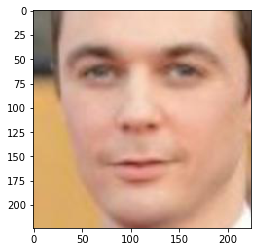

In [9]:
img, age, gender, race = train_data[138]
print("age group: ", age_dict.get(age))
print("gender: ", gender_dict.get(gender))
print("race: ", race_dict.get(race))
plt.imshow(img.numpy().transpose(1,2,0));

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=8, 
                                          shuffle=False)

age:     tensor([5, 2, 0, 5, 2, 5, 4, 3])
gender:  tensor([0, 0, 0, 0, 0, 0, 0, 0])
race:    tensor([0, 3, 3, 1, 1, 2, 3, 0])


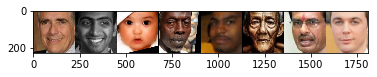

In [23]:
images, age, gender, race = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print("age:    ", age)
print("gender: ", gender)
print("race:   ", race)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F

class MTLnet(nn.Module): #Multi-task learning
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(MTLnet, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = models.mobilenet_v2(pretrained=True)
            # code here
        elif self.net == 'resnet34':
            self.model = models.resnet34(pretrained=True)
            # code here
        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained=True) # initialize the resnet50
        
        #num_features = self.model.fc.in_features
        #self.model.fc = nn.Linear(num_features, 512)
        # self.model = model core
        # heads
        

        self.model.gender_cls = nn.Linear(2048, 2)
        self.model.age_cls = nn.Linear(2048, 6)
        self.model.race_cls = nn.Linear(2048, 5)

    def forward(self, x):
        if self.net == 'resnet50':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)

        
        return age, gender, race

model = MTLnet(net='resnet50').to(device)

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)

In [27]:
%%time
from IPython.display import clear_output
print("epoch|loss |val_loss| age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|")
for epoch in range(10):  # loop over the dataset multiple times

    for phase in ['train', 'valid']:
        
        if phase == 'train':
            
            model.train(True)
            
            running_loss = 0.0
            correct = 0
            total = 0

            age_correct = 0
            gender_correct = 0
            race_correct = 0
            
            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                out_age, out_gender, out_race = model(inputs)

                loss_age = criterion(out_age, age)
                loss_gender = criterion(out_gender, gender)
                loss_race = criterion(out_race, race)
                
                loss = loss_age + loss_gender + loss_race

                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                _, age_pred = torch.max(out_age.data, 1)
                _, gender_pred = torch.max(out_gender.data, 1)
                _, race_pred = torch.max(out_race.data, 1)
                
                total += gender.size(0)
                
                age_correct += (age_pred == age).sum().item()
                gender_correct += (gender_pred == gender).sum().item()
                race_correct += (race_pred == race).sum().item()
                
        elif phase == 'valid':
            
            model.train(False)
            
            validation_loss = 0.
            v_correct = 0
            v_total = 0
            
            v_age_correct = 0
            v_gender_correct = 0
            v_race_correct = 0

            for i, v_data in enumerate(valid_loader):
                v_loss_age = 0
                v_loss_gender = 0
                v_loss_race = 0
                
                v_inputs, v_age, v_gender, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                v_out_age, v_out_gender, v_out_race = model(v_inputs)


                v_loss_age += criterion(v_out_age, v_age)
                v_loss_gender += criterion(v_out_gender, v_gender)
                v_loss_race += criterion(v_out_race, v_race)

                validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                _, v_age_pred = torch.max(v_out_age.data, 1)
                _, v_gender_pred = torch.max(v_out_gender.data, 1)
                _, v_race_pred = torch.max(v_out_race.data, 1)

                v_total += v_gender.size(0)
                
                v_age_correct += (v_age_pred == v_age).sum().item()
                v_gender_correct += (v_gender_pred == v_gender).sum().item()
                v_race_correct += (v_race_pred == v_race).sum().item()
    #print("epoch|loss |val_loss|age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|")
    print('%5d|%.3f| %.3f  | %.3f / %.3f |  %.3f / %.3f  | %.3f / %.3f |' %
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           age_correct / total, v_age_correct / v_total,
           gender_correct / total, v_gender_correct / v_total,
           race_correct / total, v_race_correct / v_total,))           

print('Finished Training')

epoch|loss |val_loss| age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|
    1|3.749| 3.609  | 0.335 / 0.359 |  0.538 / 0.662  | 0.407 / 0.430 |
    2|3.554| 3.452  | 0.360 / 0.373 |  0.689 / 0.744  | 0.425 / 0.443 |
    3|3.412| 3.286  | 0.372 / 0.393 |  0.738 / 0.781  | 0.447 / 0.486 |
    4|3.264| 3.143  | 0.394 / 0.435 |  0.759 / 0.781  | 0.479 / 0.510 |
    5|3.129| 3.020  | 0.449 / 0.459 |  0.776 / 0.794  | 0.511 / 0.541 |
    6|3.009| 2.888  | 0.480 / 0.500 |  0.781 / 0.805  | 0.544 / 0.577 |
    7|2.901| 2.784  | 0.510 / 0.509 |  0.791 / 0.818  | 0.567 / 0.596 |
    8|2.809| 2.703  | 0.523 / 0.533 |  0.795 / 0.817  | 0.582 / 0.606 |
    9|2.718| 2.625  | 0.544 / 0.543 |  0.811 / 0.832  | 0.593 / 0.609 |
   10|2.647| 2.567  | 0.546 / 0.549 |  0.812 / 0.836  | 0.608 / 0.621 |
Finished Training
Wall time: 30min 10s


# results
~~~
only GENDER
Epoch 1, loss: 0.678, val_loss: 0.642, acc_gender: 0.571, val_acc_gender: 0.681
Epoch 2, loss: 0.624, val_loss: 0.591, acc_gender: 0.704, val_acc_gender: 0.751
Epoch 3, loss: 0.587, val_loss: 0.549, acc_gender: 0.741, val_acc_gender: 0.772
Epoch 4, loss: 0.550, val_loss: 0.512, acc_gender: 0.766, val_acc_gender: 0.787
Epoch 5, loss: 0.519, val_loss: 0.482, acc_gender: 0.775, val_acc_gender: 0.794
Epoch 6, loss: 0.494, val_loss: 0.456, acc_gender: 0.781, val_acc_gender: 0.805
Epoch 7, loss: 0.466, val_loss: 0.434, acc_gender: 0.793, val_acc_gender: 0.813
Epoch 8, loss: 0.444, val_loss: 0.418, acc_gender: 0.803, val_acc_gender: 0.818
Epoch 9, loss: 0.422, val_loss: 0.409, acc_gender: 0.814, val_acc_gender: 0.823
Epoch 10, loss: 0.409, val_loss: 0.384, acc_gender: 0.819, val_acc_gender: 0.832
Finished Training
~~~

~~~
RESNET50
epoch|loss |val_loss| age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|
    1|3.749| 3.609  | 0.335 / 0.359 |  0.538 / 0.662  | 0.407 / 0.430 |
    2|3.554| 3.452  | 0.360 / 0.373 |  0.689 / 0.744  | 0.425 / 0.443 |
    3|3.412| 3.286  | 0.372 / 0.393 |  0.738 / 0.781  | 0.447 / 0.486 |
    4|3.264| 3.143  | 0.394 / 0.435 |  0.759 / 0.781  | 0.479 / 0.510 |
    5|3.129| 3.020  | 0.449 / 0.459 |  0.776 / 0.794  | 0.511 / 0.541 |
    6|3.009| 2.888  | 0.480 / 0.500 |  0.781 / 0.805  | 0.544 / 0.577 |
    7|2.901| 2.784  | 0.510 / 0.509 |  0.791 / 0.818  | 0.567 / 0.596 |
    8|2.809| 2.703  | 0.523 / 0.533 |  0.795 / 0.817  | 0.582 / 0.606 |
    9|2.718| 2.625  | 0.544 / 0.543 |  0.811 / 0.832  | 0.593 / 0.609 |
   10|2.647| 2.567  | 0.546 / 0.549 |  0.812 / 0.836  | 0.608 / 0.621 |
Finished Training
Wall time: 30min 10s
~~~

In [32]:
path = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\2-UTKFace\\UTKFace_MTL_resnet50.pth'

In [33]:
torch.save(model.state_dict(), path)